<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Exchange_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 노트북은 지난 5 시간 동안의 데이터를 보고 향후 15 분 동안 EURUSD의 입찰 가격을 예측하는 LSTM 모델을 TRAIN합니다. 입력이 인접해야 한다는 요구 사항은 없지만 연속 입력을 사용하면 모델의 정확성이 향상된다는 것이 경험적으로 관찰되었습니다. Feature들에서 계절성과 연속성 문제를 완화시키는 요일과 시간대를 선정하는 것이 좋다.

면책 조항 :이 연습은 14880 샘플 (2015-12-29 00:00:00 - 2016-05-31 23:45:00) 만 포함하고 ASK 가격이없는 작은 샘플 데이터를 사용하여 수행되었습니다. 이는 모델이 더 나은 정확도에 접근하는 것을 제한합니다.

개량

* 모델을 추가로 조정하려면 적어도 5 년 분의 데이터를 보유하고 ASK 가격 (스프레드를 계산할 수 있도록)을 지정하고 기간을 3000으로 늘리는 것이 좋습니다.
* 더 많은 교차 축 기능 추가. 그런 퍼짐.
* 분류 접근법 (PASS, BUY, SELL)을 검토하는 경우 최신 데이터에보다 민감한 기술 지표를 추가하는 것이 좋습니다.
* 숫자가 아닌 데이터를 추가하는 것이 좋습니다. 뉴스, 트윗. 캐치는 거래를 위해 1 분 이내에 데이터를 가져와야한다는 것입니다. 그렇지 않으면 거래를하기 전에 뉴스가 반영됩니다. 정말 빨리 뉴스를 스트리밍하는 방법을 아는 사람이 있으면 알려 주시기 바랍니다.

크레딧 : Dave Y. Kim, Mahmoud Elsaftawy,

In [0]:
! mkdir input

In [0]:
! mv EURUSD_* ./input

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

EURUSD_15m_BID_01.01.2010-31.12.2016.csv
EURUSD_15m_BID_sample.csv



Data Loading을 수행 한다.
csv형태의 data set을 불러들일 경우 read_csv함수를 사용한다.

In [0]:
# Load sample data
df = pd.read_csv('./input/EURUSD_15m_BID_sample.csv')

데이터 각각의 컬럼에 null check를 위해 count()함수를 통해 컬럼 내부 체크를 수행한다.

In [7]:
df.count()

Time      14880
Open      14880
High      14880
Low       14880
Close     14880
Volume    14880
dtype: int64

In [8]:
df.index.min(), df.index.max()

(0, 14879)

In [0]:
# FULL DATA (takes too long)
# df = pd.read_csv('../input/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')

향후 처리를 손쉽게 하기 위하여 컬럼 index를 Rename화 한다

Open High Low Close 컬럼명의 앞문자를 소문자로 치환한다.
dataframe에 저장된 숫자의 형을 float 형태로 변환하고 head에 위치한 데이터를 출력하여 확인한다.

In [10]:
# Rename bid OHLC columns
df.rename(columns={'Time' : 'timestamp', 'Open' : 'open', 'Close' : 'close', 
                   'High' : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp', inplace=True)
df = df.astype(float)
df.head()

,open,high,low,close,volume
timestamp,,,,,
2015-12-29 00:00:00,1.09746,1.09783,1.09741,1.09772,4.866800e+08
2015-12-29 00:15:00,1.09772,1.09800,1.09770,1.09790,4.459200e+08
2015-12-29 00:30:00,1.09790,1.09805,1.09782,1.09792,1.210700e+09
2015-12-29 00:45:00,1.09792,1.09825,1.09775,1.09808,1.116910e+09
2015-12-29 01:00:00,1.09808,1.09824,1.09791,1.09822,5.038800e+08


모델의 정확도를 제한하는 ASK 관련 기능을 추가 할 수 없습니다.

In [0]:
# Add additional features
df['hour'] = df.index.hour
df['day']  = df.index.weekday
df['week'] = df.index.week
df['momentum']  = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high'])/2
df['range']     = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']    = df['open'] - df['close']

# Cannot add ASK related features, which will limit the accuracy of the model

차원을 줄이는 대신 PCA를 기능으로 추가하십시오. 이것은 약간의 정확도를 향상시킵니다.
주성분 분석(主成分分析, Principal component analysis; PCA)은 고차원의 데이터를 저차원의 데이터로 환원시키는 기법이다. 서로 연관 가능성이 있는 고차원 공간의 표본들을 선형 연관성이 없는 저차원 공간(주성분)의 표본으로 변환하기 위해 직교 변환을 사용한다. 주성분의 차원수는 원래 표본의 차원수보다 작거나 같다. 주성분 분석은 데이터를 한개의 축으로 사상시켰을 때 그 분산이 가장 커지는 축을 첫 번째 주성분, 두 번째로 커지는 축을 두 번째 주성분으로 놓이도록 새로운 좌표계로 데이터를 선형 변환한다. 이와 같이 표본의 차이를 가장 잘 나타내는 성분들로 분해함으로써 여러가지 응용이 가능하다. 이 변환은 첫째 주성분이 가장 큰 분산을 가지고, 이후의 주성분들은 이전의 주성분들과 직교한다는 제약 아래에 가장 큰 분산을 갖고 있다는 식으로 정의되어있다. 중요한 성분들은 공분산 행렬의 고유 벡터이기 때문에 직교하게 된다.

In [0]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

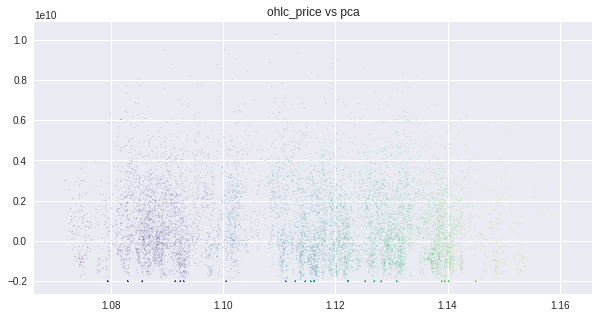

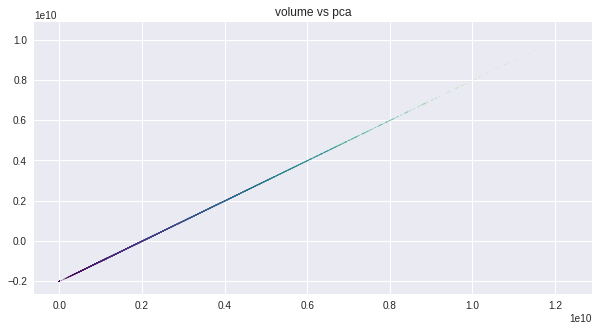

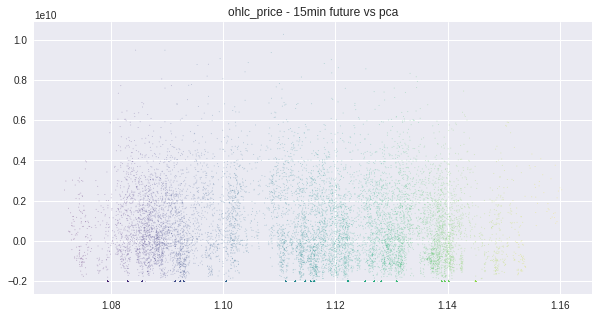

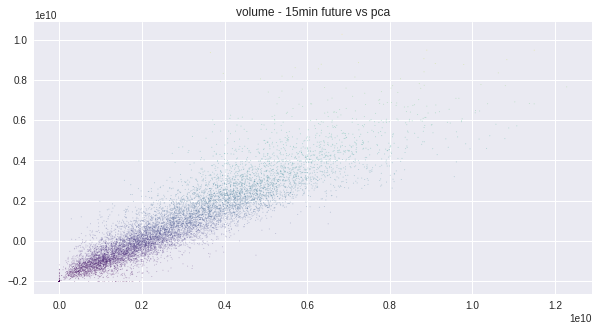

In [13]:
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
color = cm.viridis(norm(df['volume'].values))
plt.scatter(df['volume'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('volume - 15min future vs pca')
plt.show()

위에서 살펴본 것처럼 PCA를 사용하면 데이터를 다른 가격 그룹으로 다소 클러스터링하는 데이터 분리 가능성이 나타납니다.

In [14]:
df.head()

,open,high,low,close,volume,hour,day,week,momentum,avg_price,range,ohlc_price,oc_diff,pca
timestamp,,,,,,,,,,,,,,
2015-12-29 00:00:00,1.09746,1.09783,1.09741,1.09772,4.866800e+08,0,1,53,-126536.800832,1.097620,0.00042,1.097605,-0.00026,-1.525346e+09
2015-12-29 00:15:00,1.09772,1.09800,1.09770,1.09790,4.459200e+08,0,1,53,-80265.599838,1.097850,0.00030,1.097830,-0.00018,-1.566106e+09
2015-12-29 00:30:00,1.09790,1.09805,1.09782,1.09792,1.210700e+09,0,1,53,-24214.000100,1.097935,0.00023,1.097923,-0.00002,-8.013260e+08
2015-12-29 00:45:00,1.09792,1.09825,1.09775,1.09808,1.116910e+09,0,1,53,-178705.598720,1.098000,0.00050,1.098000,-0.00016,-8.951159e+08
2015-12-29 01:00:00,1.09808,1.09824,1.09791,1.09822,5.038800e+08,1,1,53,-70543.200420,1.098075,0.00033,1.098113,-0.00014,-1.508146e+09


In [0]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

Doing a bit of features analysis (몇 가지 기능 분석하기)

Pearson correlation of features (Features의 피어슨 상관관계)

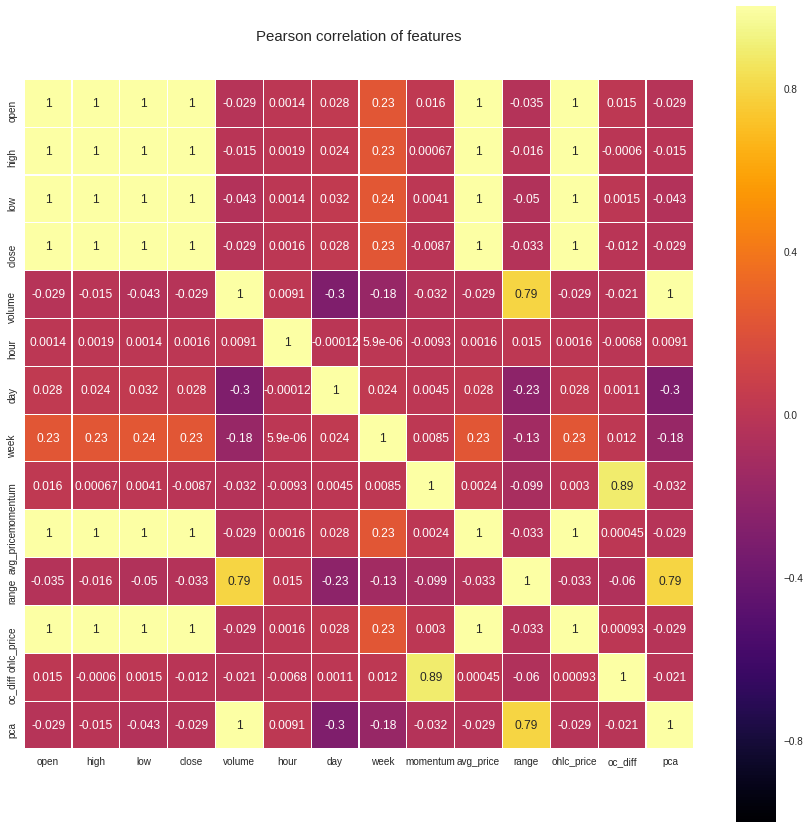

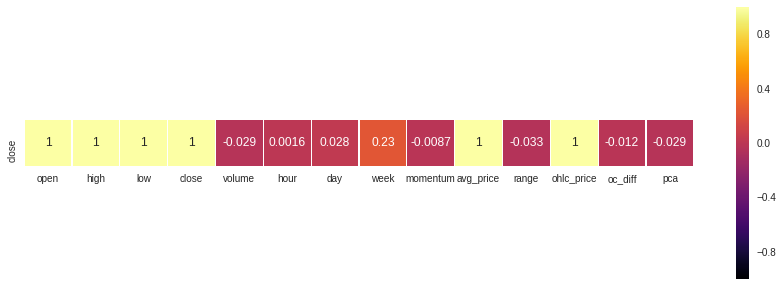

In [16]:
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

RandomForestRegressor
Random Forest의 숲은 수많은 의사 결정 트리가 모여서 생성
이렇게 많은 의사 결정 트리로 ‘숲’을 만들었는데, 의견 통합이 되지 않는다면 어떻게 해야 할까요? 이 역시 현실과 비슷합니다. 의견 통합이 이루어지지 않을 경우 다수결의 원칙을 따르듯이, 저희의 의사 결정 ‘숲'도 투표로 결정을 내리게 됩니다. 1,000개의 의사 결정 트리 중 678개의 트리가 건강 위험도가 높다고 의견을 내고, 나머지는 위험도가 낮다는 의견을 냈을 경우, 숲은 그 의견들을 통합하여 건강 위험도가 높다고 하는 것이죠. 데이터 사이언스에서는 이렇게 의견을 통합하거나 여러가지 결과를 합치는 방식을 “앙상블” (Ensemble method)이라고 합니다.

In [0]:
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
target_index = df.columns.tolist().index('close')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]
X = np.reshape(X, (X.shape[0], X.shape[2]))

In [0]:
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

Feature ranking:
0. close 3 (0.792045)
1. ohlc_price 11 (0.079596)
2. high 1 (0.076055)
3. avg_price 9 (0.050477)
4. low 2 (0.001396)
5. open 0 (0.000090)
6. momentum 8 (0.000060)
7. range 10 (0.000059)
8. volume 4 (0.000047)
9. pca 13 (0.000045)
10. oc_diff 12 (0.000043)
11. hour 5 (0.000038)
12. week 7 (0.000027)


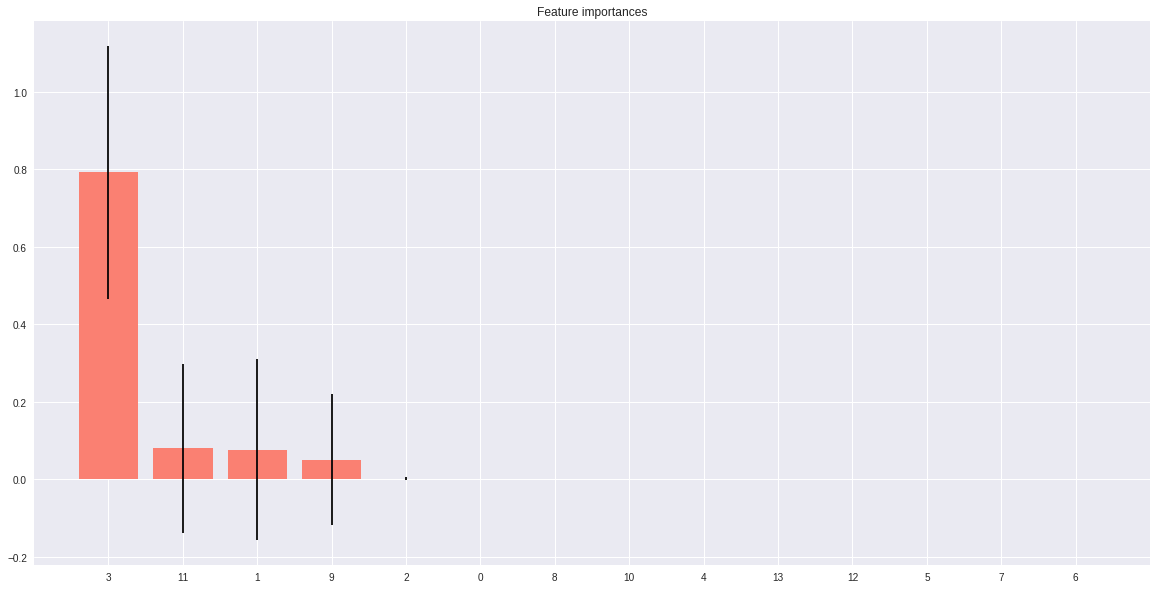

In [32]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

**Data Exploration**

종가 데이터를 바탕으로 전체 그래프를 그려보고
이를 바탕으로 초기 2015년 12월 29일 부터 2015년 12월 31일까지 차트를 zoomed한 것을 그려본다.

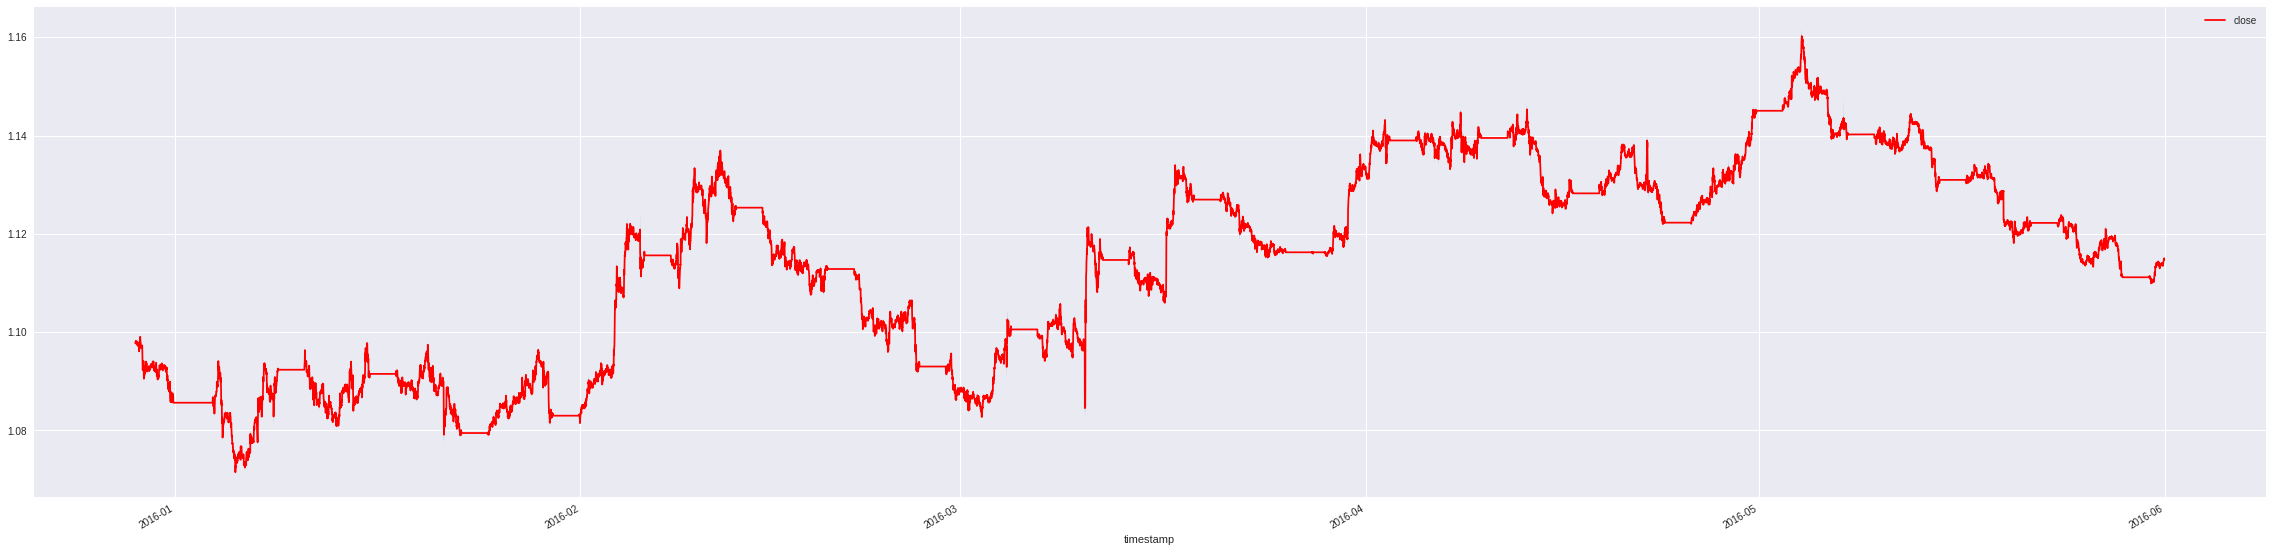

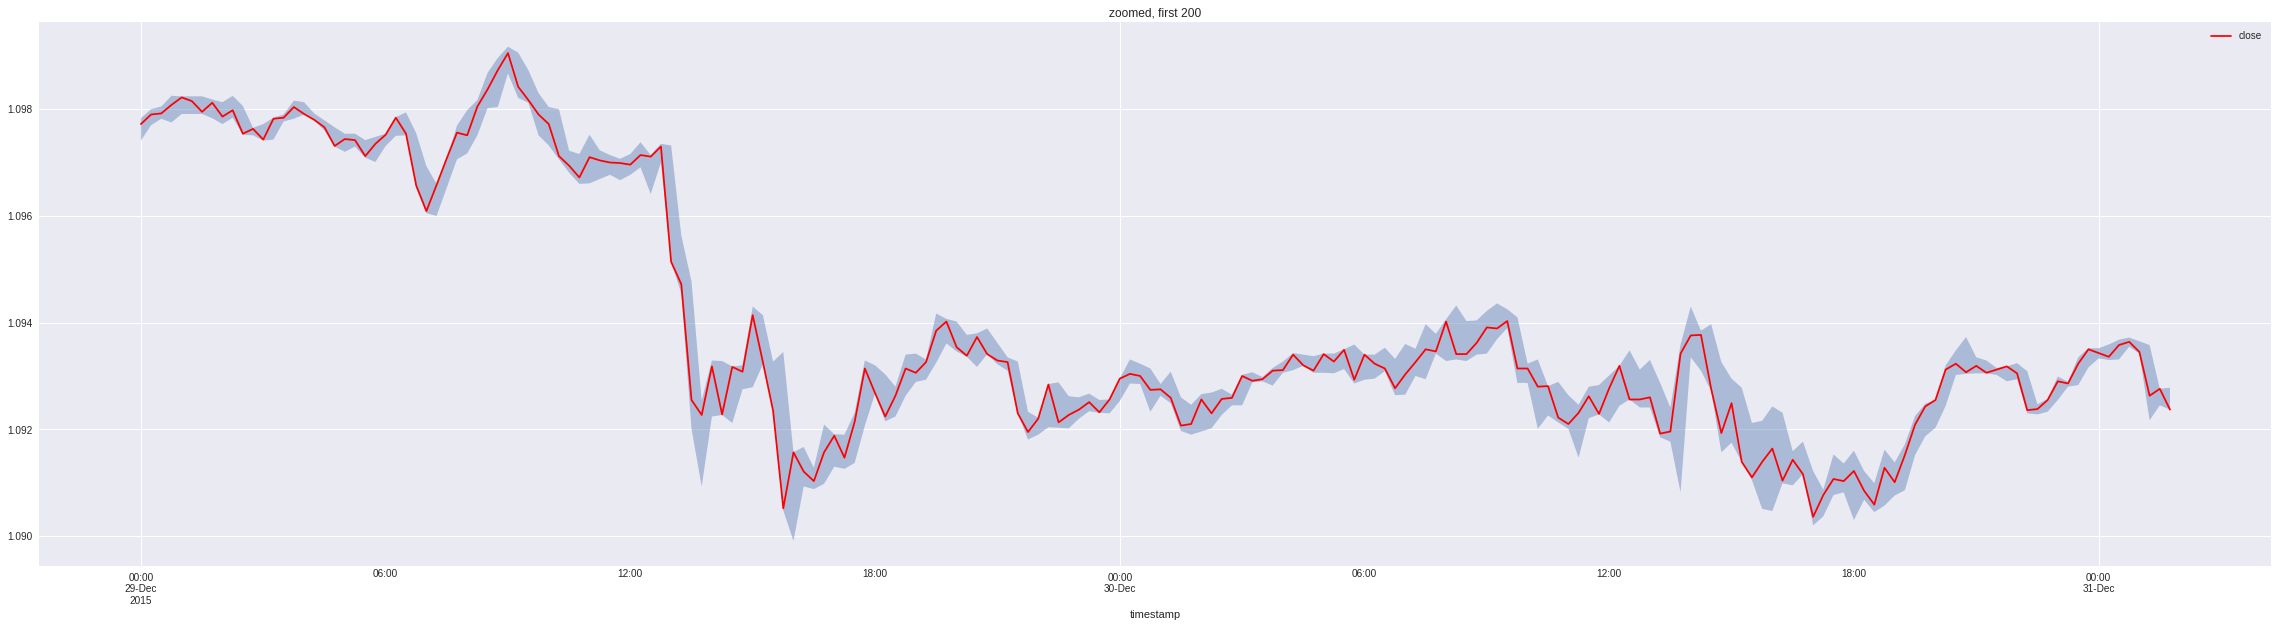

In [53]:
ax = df.plot(x=df.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low',y2='high', data=df, alpha=0.4)
plt.show()

p = df[:200].copy()
ax = p.plot(x=p.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

Scale and Create Datasets (데이터 집합 크기 조정 및 생성)

Scale the data (데이터 크기 조정)

Create y_scaler to inverse it later (나중에 y_scaler를 만들어 반전)

Set look_back to 20 which is 5 hours (15min*20) (look_back을 20으로 설정하고 5 시간 (15 분 * 20))


In [0]:
# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=20)
y = y[:,target_index]

Set training data size (training data 크기 설정)

We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets

우리는 충분히 큰 데이터 세트를 가지고 있습니다. 98 % 훈련 / 1 % 개발 / 1 % 시험 세트로 나누기

In [0]:
# Set training data size
# We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

create a small LSTM network (작은 LSTM network를 만든다)

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 20)            2800      
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 20)            3280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 10)            1240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 10)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total para

Save the best weight during training. (training 동안 최상의 weight를 유지하기)

In [37]:
# Save the best weight during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=200, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error improved from inf to 0.29472, saving model to weights.best.hdf5

Epoch 00002: val_mean_squared_error improved from 0.29472 to 0.23325, saving model to weights.best.hdf5

Epoch 00003: val_mean_squared_error improved from 0.23325 to 0.15183, saving model to weights.best.hdf5

Epoch 00004: val_mean_squared_error improved from 0.15183 to 0.07124, saving model to weights.best.hdf5

Epoch 00005: val_mean_squared_error improved from 0.07124 to 0.02558, saving model to weights.best.hdf5

Epoch 00006: val_mean_squared_error improved from 0.02558 to 0.01487, saving model to weights.best.hdf5

Epoch 00007: val_mean_squared_error improved from 0.01487 to 0.01431, saving model to weights.best.hdf5

Epoch 00008: val_mean_squared_error did not improve from 0.01431

Epoch 00009: val_mean_squared_error did not improve from 0.01431

Epoch 00010: val_mean_squared_error improved from 0.01431 to 0.00365, saving model to weights.best.hdf5

Epoch 00011: val_mean_squared_e

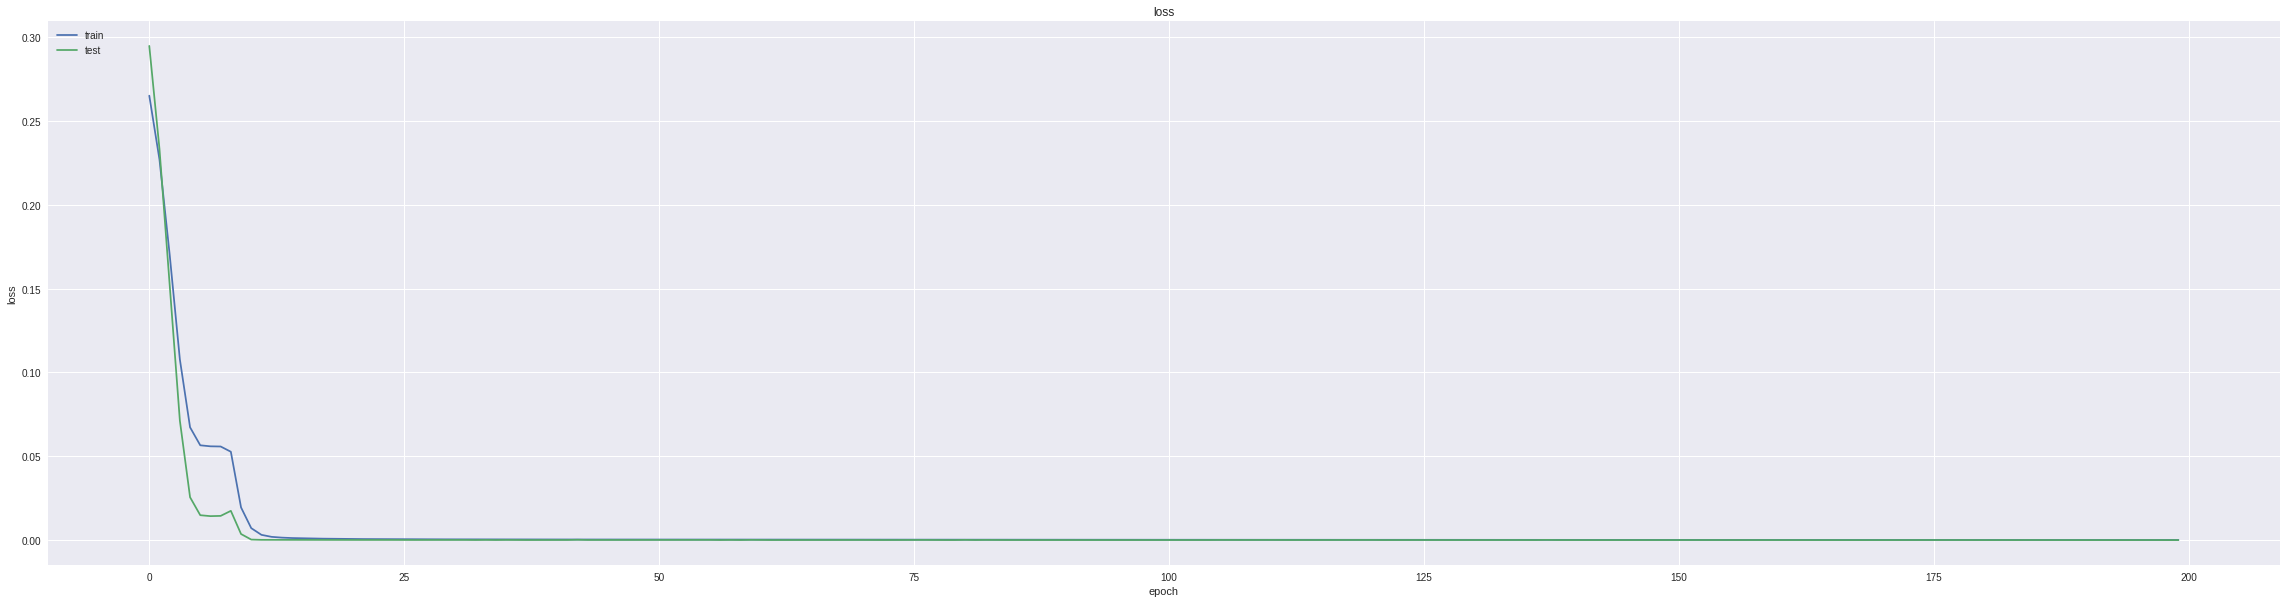

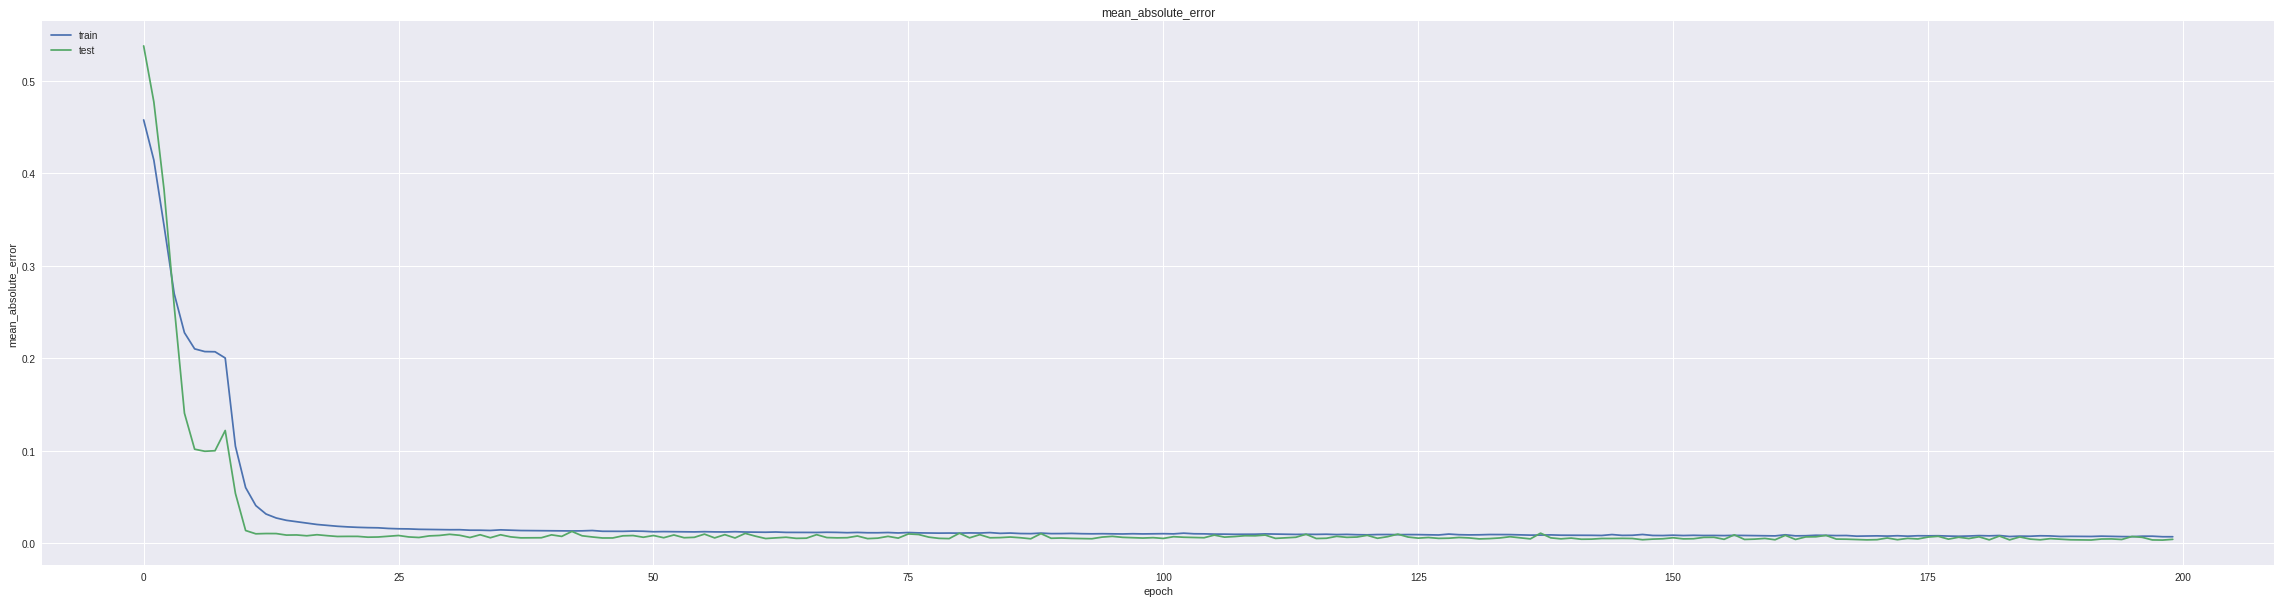

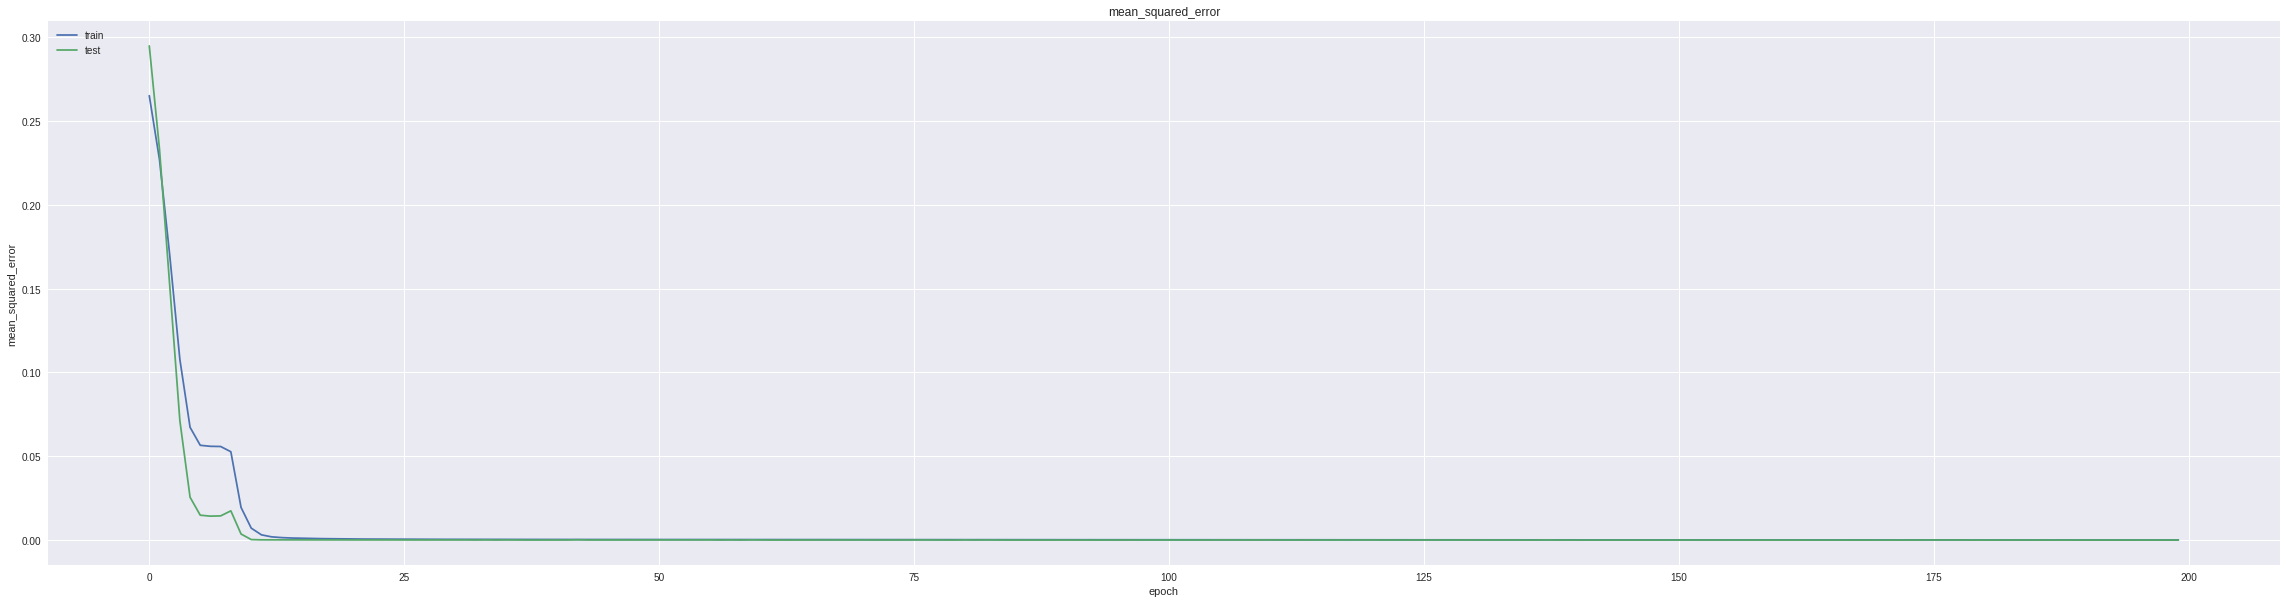

In [38]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [39]:
min(history.history['val_mean_absolute_error'])

0.00331970234987162

Baby the model a bit (초기 모델)
Load the weight that worked the best (가장 잘 동작한 weight 로드)
Train again with decaying learning rate (쇠퇴하는 learning rate로 재 훈련)

In [40]:
# Baby the model a bit
# Load the weight that worked the best
model.load_weights("weights.best.hdf5")

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)


Epoch 00001: val_mean_squared_error did not improve from 0.00003

Epoch 00002: val_mean_squared_error did not improve from 0.00003
lr changed to 0.0009000000427477062

Epoch 00003: val_mean_squared_error did not improve from 0.00003

Epoch 00004: val_mean_squared_error did not improve from 0.00003
lr changed to 0.0008100000384729356

Epoch 00005: val_mean_squared_error improved from 0.00003 to 0.00003, saving model to weights.best.hdf5

Epoch 00006: val_mean_squared_error did not improve from 0.00003
lr changed to 0.0007290000503417104

Epoch 00007: val_mean_squared_error did not improve from 0.00003

Epoch 00008: val_mean_squared_error did not improve from 0.00003
lr changed to 0.0006561000715009868

Epoch 00009: val_mean_squared_error did not improve from 0.00003

Epoch 00010: val_mean_squared_error did not improve from 0.00003
lr changed to 0.0005904900433961303

Epoch 00011: val_mean_squared_error did not improve from 0.00003

Epoch 00012: val_mean_squared_error improved from 0.00

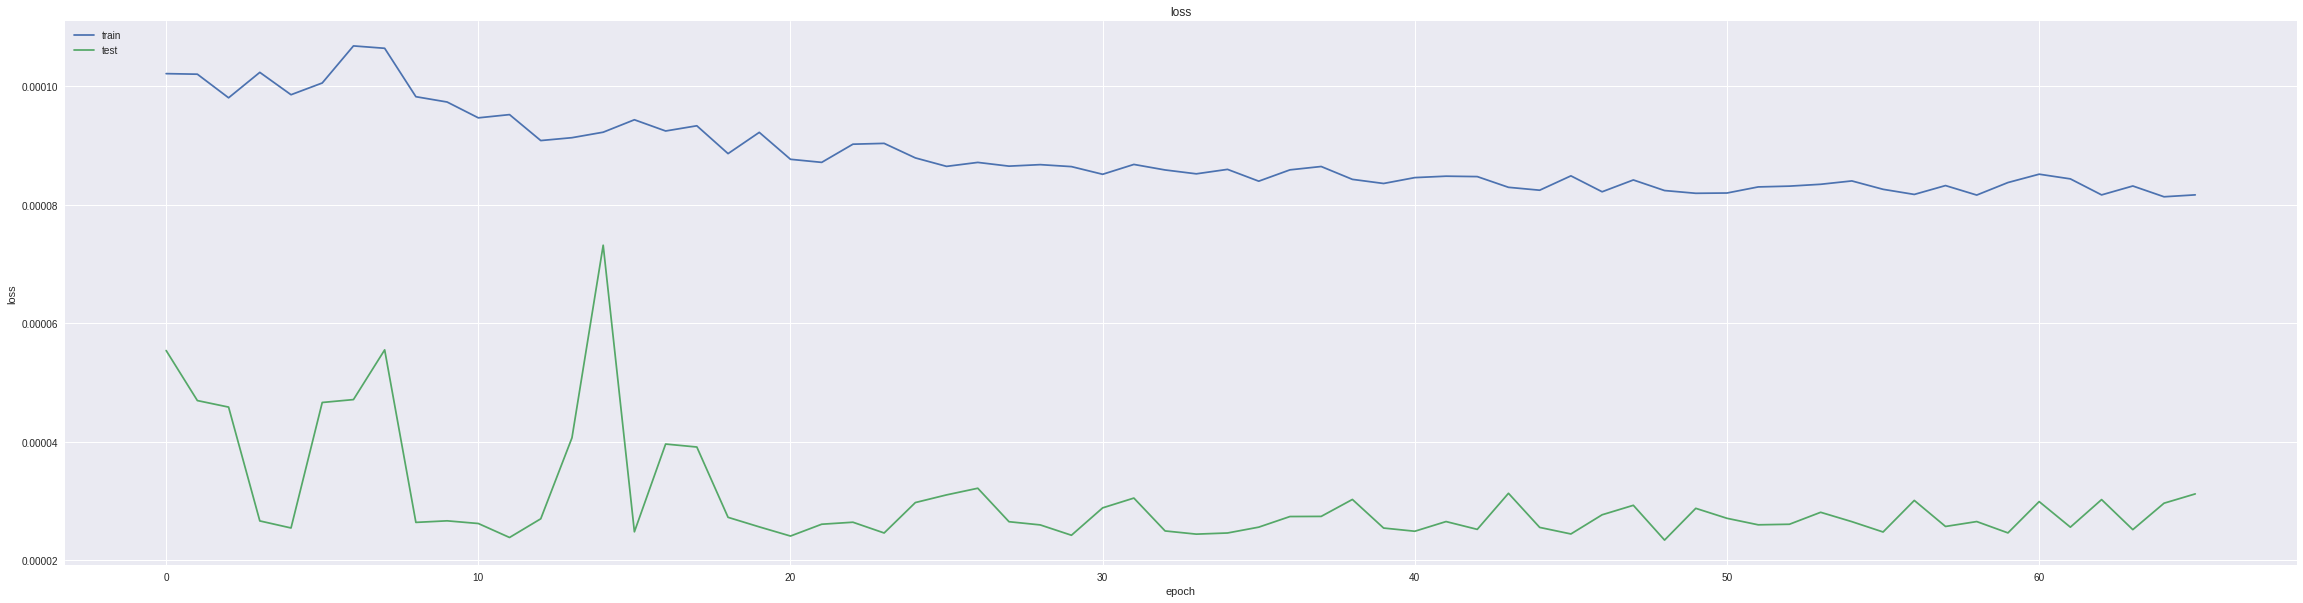

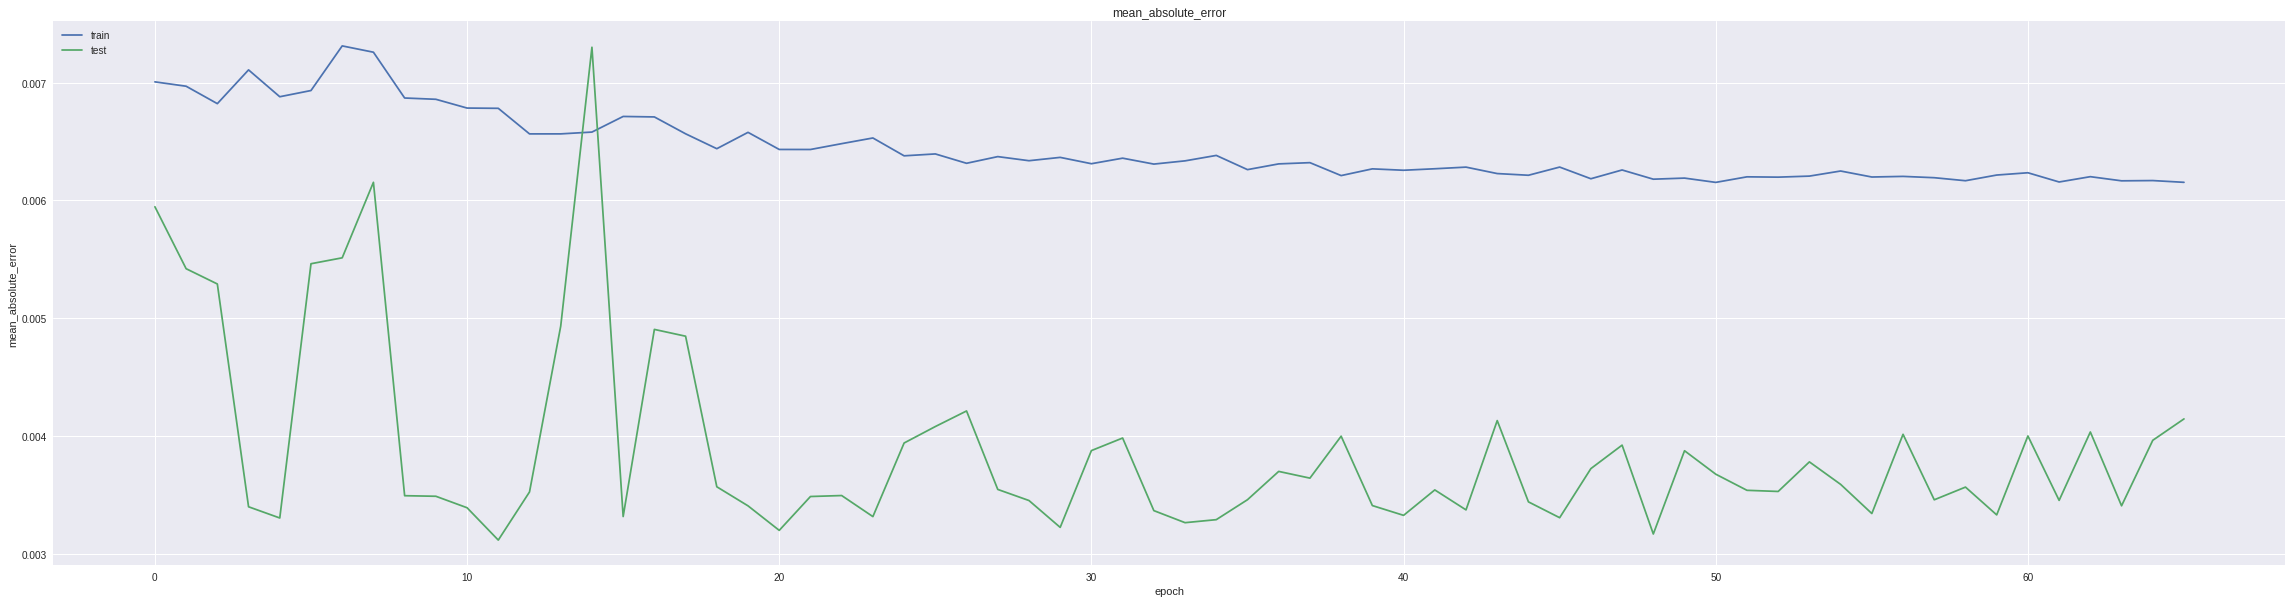

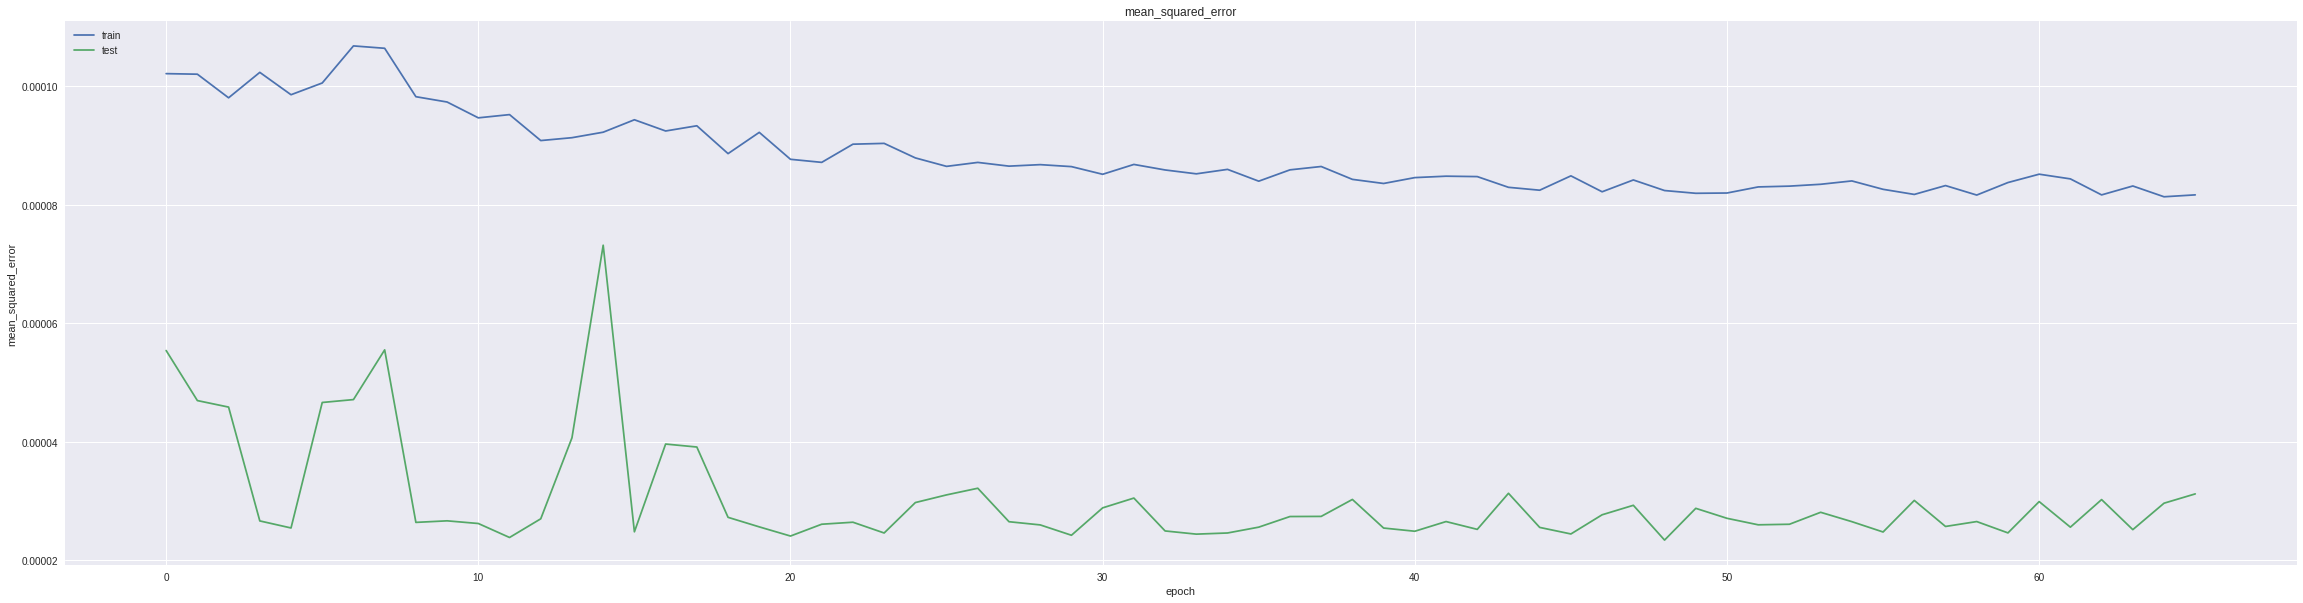

KeyError: ignored

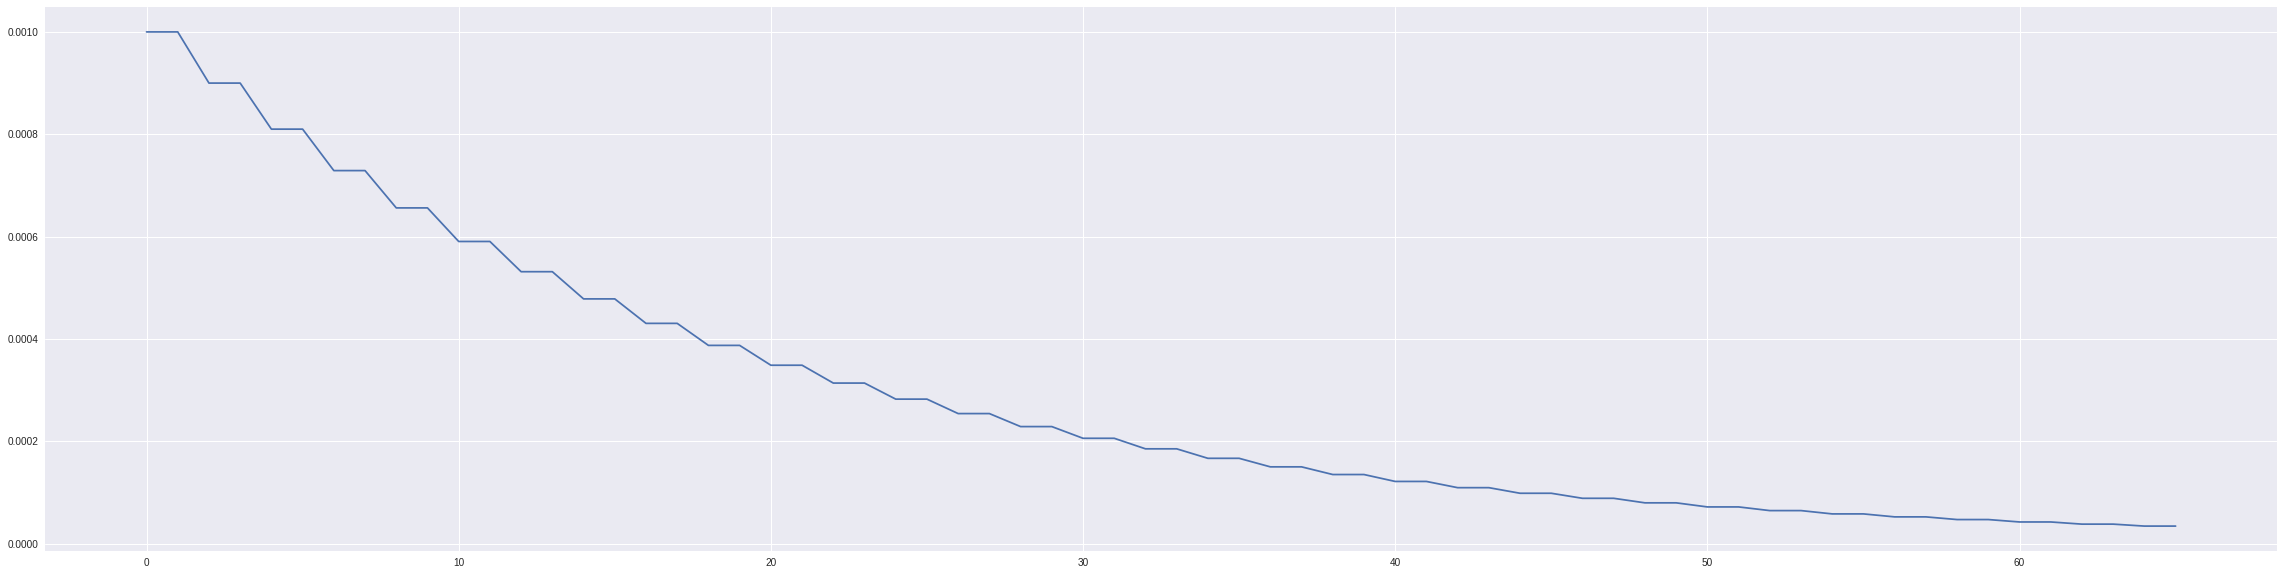

In [44]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_'+k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [45]:
min(history.history['val_mean_absolute_error'])

0.0031163232577654434

예측값과 실제값을 차트로 그려 보여준다

예측값에서 실제값을 뺀 것을 차이라고 하고 difff를 

Distribution of differences between actual and prediction(실제와 예측 간의 차이 분포)를 하단 표로 나타낸다.

통계에서 추정치의 평균 자승 오차 (Mean Squared Error) 또는 관찰되지 않은 양을 추정하는 절차의 평균 제곱 편차 (Mean Squared Deviation)는 오차의 제곱 평균을 측정합니다. 즉, 추정 된 오차의 평균 제곱 오차 가치와 추정치. MSE는 위험 함수로서 제곱 오류 손실의 예상 값에 해당합니다. MSE가 거의 항상 엄격하게 (0이 아닌) 엄밀하게 긍정적이라는 사실은 임의성 때문에 또는 평가자가보다 정확한 추정을 산출 할 수있는 정보를 설명하지 않기 때문에 발생합니다.

MSE는 평가자의 품질을 측정 한 것으로, 항상 음수가 아니며 0에 가까운 값이 더 좋습니다.

통계에서 평균 절대 오차 (MAE)는 두 개의 연속 변수 간의 차이를 측정 한 것입니다. X와 Y는 같은 현상을 나타내는 쌍으로 된 관측치의 변수라고 가정합니다. Y 대 X의 예에는 예측 시간 대 관찰 시간, 초기 시간 대 후속 시간 비교, 대체 측정 기술 대 측정 기술 한 가지가 포함됩니다. 평균 절대 오차 (Mean Absolute Error, MAE)는 각 점과 항등 선 사이의 평균 수직 거리입니다. MAE는 또한 각 점과 동일 선 간의 평균 수평 거리입니다.


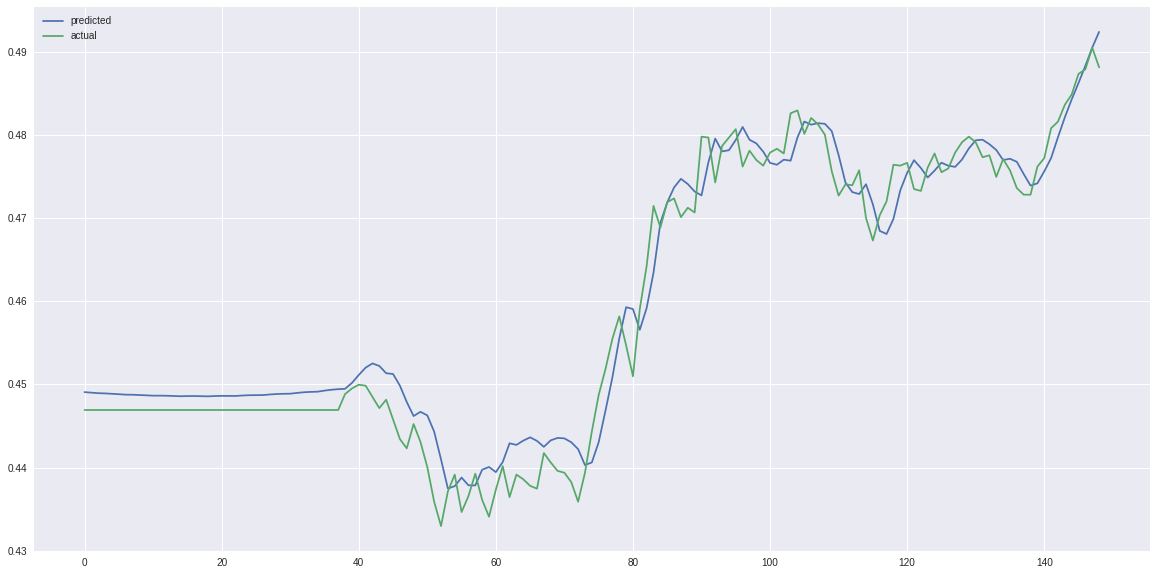

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


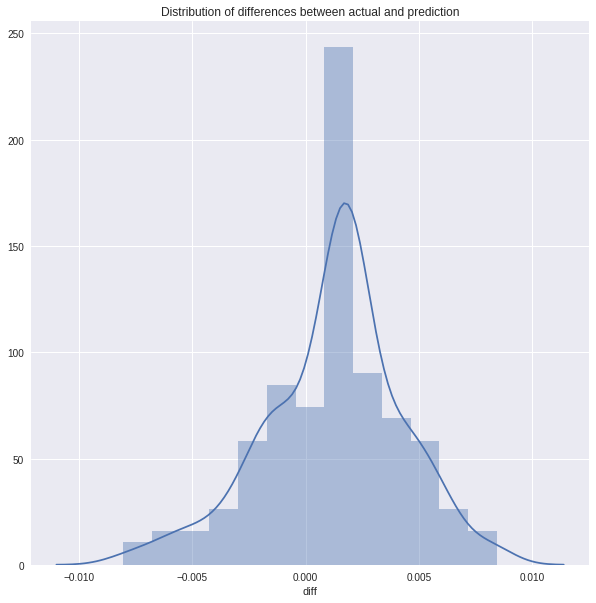

MSE :  1.067728858166001e-05
MAE :  0.0026736351467619005


count    149.000000
mean       0.001218
std        0.003042
min       -0.008038
25%       -0.000745
50%        0.001689
75%        0.002656
max        0.008441
Name: diff, dtype: float64

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights("weights.best.hdf5")

pred = model.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

첫번째 표 Prediction vs Actual (low and high as blue region) 예측 대 실제 (파란색 영역으로 낮고 높음)

두번째 표 Distribution of differences between actual and prediction (실제와 예측 간의 차이 분포)

세번째 표 Distributtion of error and price (Error 와 가격의 분포)

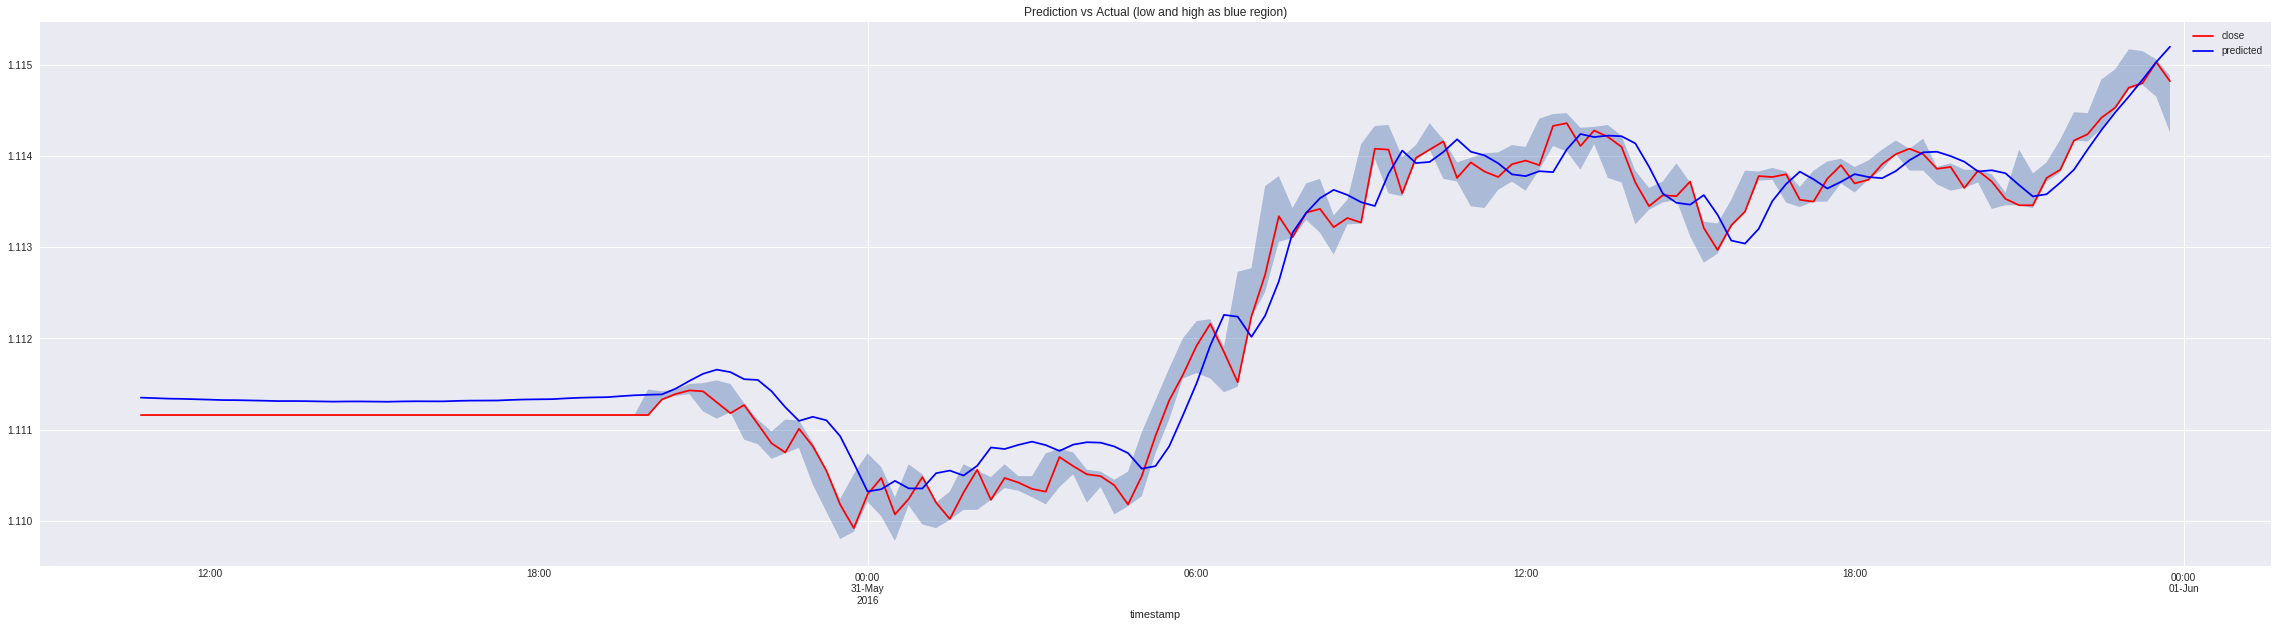

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


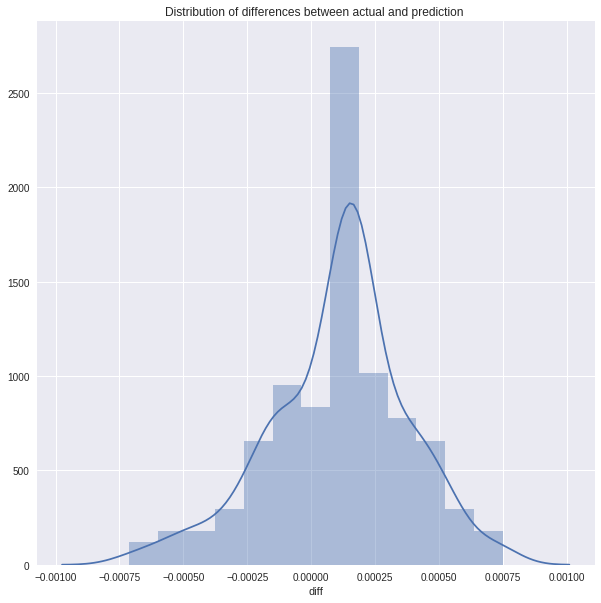

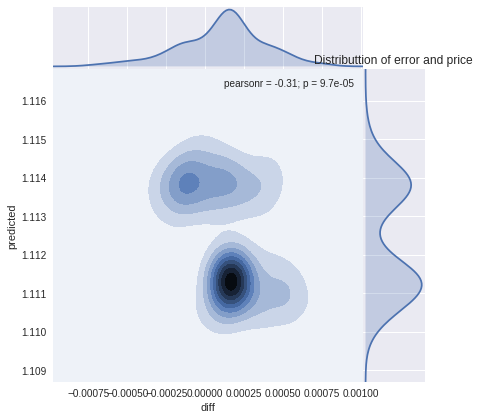

MSE :  8.408568257189644e-08
MAE :  0.00023726728938569958


count    149.000000
mean       0.000108
std        0.000270
min       -0.000713
25%       -0.000066
50%        0.000150
75%        0.000236
max        0.000749
Name: diff, dtype: float64

In [47]:
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

ax = predictions.plot(x=predictions.index, y='close', c='red', figsize=(40,10))
ax = predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()